In [24]:
import sys,os
os.environ['PROJ_LIB'] = '/home/piotr/anaconda3/lib/python3.8/site-packages/rasterio/proj_data/'
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stat
import warnings
warnings.filterwarnings('ignore')


# Forecasting
- operates using a single function for all pre-set forecast targets and forecast months
- forecast month is the month for which all predictor data are available. That will typically be the month that is previous to current
- the functions are possibly extendable, i.e. additional predictands data can be added and additional target variables can be defined

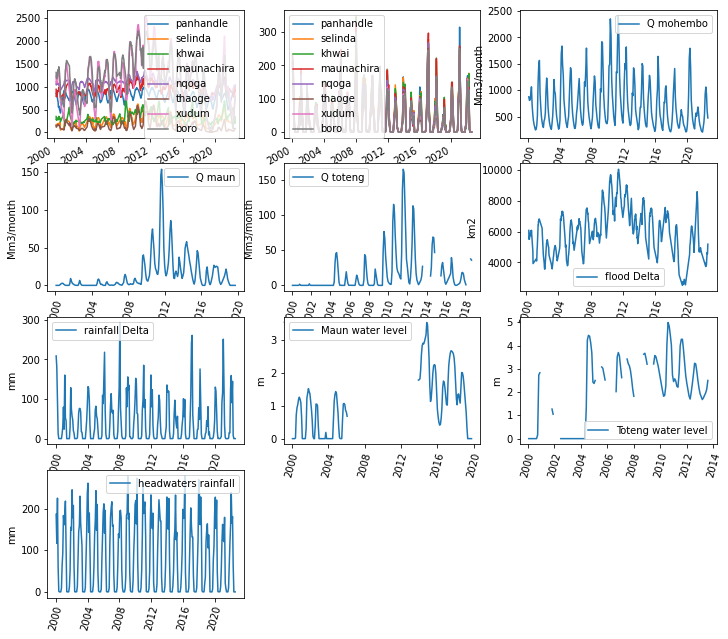

In [25]:
#setting things up
#this is period over which data are used in forecast. 
#it cannot start earlier than 2000 because MODIS inundation maps are available only after 2000
fy,ly="2000","2022"
datadir="../data/"
verbose=True

#reading data
#these files are generated using download and preprocess notebooks
unitfl=pd.read_csv(datadir+"flood/flood_deltaunits.csv", index_col=0, parse_dates=True)[fy:ly]
mohq=pd.read_csv(datadir+"/gauge/mohembo_mon.csv", index_col=0, parse_dates=True)['discharge'][fy:ly]
mauq=pd.read_csv(datadir+"/gauge/maun_mon.csv", index_col=0, parse_dates=True)['discharge'][fy:ly]
totq=pd.read_csv(datadir+"/gauge/toteng_mon.csv", index_col=0, parse_dates=True)['discharge'][fy:ly]
unitpr=pd.read_csv(datadir+"/rainfall/pr_deltaunits.csv", index_col=0,parse_dates=True)[fy:ly]
mauh=pd.read_csv(datadir+"/gauge/maun_mon.csv", index_col=0, parse_dates=True)['water level'][fy:ly]
toth=pd.read_csv(datadir+"/gauge/toteng_mon.csv", index_col=0, parse_dates=True)['water level'][fy:ly]
okapr=pd.read_csv(datadir+"/rainfall/pr_headwaters.csv", index_col=0, parse_dates=True)['pr'][fy:ly]

#these files are generated by a separate script from all MODIS images. There is no need to regenerate
flparamsfiletemplate=datadir+"flood/flood_probabilty_{}.nc"

#calculating rainfall and inundation for the entire Delta
delfl=unitfl.sum(1)
delpr=unitpr.mean(1)

#this just plots a couple of figures to give an overview of all source data
if verbose:
    nx,ny=3,4
    fig=plt.figure(figsize=(12,12))
    pl=fig.add_subplot(ny,nx,1)
    unitfl.plot(ax=pl)
    plt.legend()

    pl=fig.add_subplot(ny,nx,2)
    unitpr.plot(ax=pl)
    plt.legend()

    pl=fig.add_subplot(ny,nx,3)
    pl.plot(mohq, label="Q mohembo")
    pl.set_ylabel("Mm3/month")
    plt.xticks(rotation=75)
    plt.legend()
    
    pl=fig.add_subplot(ny,nx,4)
    pl.plot(mauq, label="Q maun")
    pl.set_ylabel("Mm3/month")
    plt.xticks(rotation=75)
    plt.legend()
    
    pl=fig.add_subplot(ny,nx,5)
    pl.plot(totq, label="Q toteng")
    pl.set_ylabel("Mm3/month")
    plt.xticks(rotation=75)
    plt.legend()

    pl=fig.add_subplot(ny,nx,6)
    pl.plot(delfl, label="flood Delta")
    pl.set_ylabel("km2")
    plt.xticks(rotation=75)
    plt.legend()
    
    pl=fig.add_subplot(ny,nx,7)
    pl.plot(delpr, label="rainfall Delta")
    pl.set_ylabel("mm")
    plt.xticks(rotation=75)
    plt.legend()

    pl=fig.add_subplot(ny,nx,8)
    pl.plot(mauh, label="Maun water level")
    pl.set_ylabel("m")
    plt.xticks(rotation=75)
    plt.legend()

    pl=fig.add_subplot(ny,nx,9)
    pl.plot(toth, label="Toteng water level")
    pl.set_ylabel("m")
    plt.xticks(rotation=75)
    plt.legend()

    pl=fig.add_subplot(ny,nx,10)
    pl.plot(okapr, label="headwaters rainfall")
    pl.set_ylabel("mm")
    plt.xticks(rotation=75)
    plt.legend()

    plt.show()    

In [3]:
#here, targets of forecast are defined
#for each target 
# - a definition of candidate predictors for each month of forecast
# - name of the predicand variable - allows data to be selected from the dataframe
# - unit of the variable - for including in plots
# - type of the variable (area, discharge, water level, day of year) - to allow diversification of figures and post processing 
# - domain - as above
alltargets={
    "maximum_inundation_delta":[{
        "Jan":['mohq_NovJan',"delpr_JulJan","delpr_NovJan","delfl_maxprev","okapr_NovJan","okapr_JulJan"],
        "Feb":['mohq_NovFeb',"delpr_JulFeb","delpr_NovFeb","delfl_maxprev","okapr_NovFeb","okapr_JulFeb"],
        "Mar":['mohq_NovMar',"delpr_JulMar","delpr_NovMar","delfl_maxprev","okapr_NovMar","okapr_JulMar"],
        "Apr":['mohq_NovApr',"delpr_JulApr","delpr_NovApr","delfl_maxprev","delfl_Apr","okapr_NovApr","okapr_JulApr"],
        "May":['mohq_NovMay',"delpr_JulMay","delpr_NovMay","delfl_maxprev","delfl_May","okapr_NovMay","okapr_JulMay"],
    },"delfl_max","km2","area","delta"],

    "day_maximum_inundation_delta":[{
        "Jan":['mohq_NovJan',"delpr_JulJan","delpr_NovJan","delfl_maxprev","okapr_NovJan","okapr_JulJan"],
        "Feb":['mohq_NovFeb',"delpr_JulFeb","delpr_NovFeb","delfl_maxprev","okapr_NovFeb","okapr_JulFeb"],
        "Mar":['mohq_NovMar',"delpr_JulMar","delpr_NovMar","delfl_maxprev","okapr_NovMar","okapr_JulMar"],
        "Apr":['mohq_NovApr',"delpr_JulApr","delpr_NovApr","delfl_maxprev","delfl_Apr","okapr_NovApr","okapr_JulApr"],
        "May":['mohq_NovMay',"delpr_JulMay","delpr_NovMay","delfl_maxprev","delfl_May","okapr_NovMay","okapr_JulMay"],
    },"delfl_dayofmax","day of year","time","delta"],

    "day_maximum_inundation_boro":[{
        "Jan":['mohq_NovJan',"delpr_JulJan","delpr_NovJan","borfl_maxprev","okapr_NovJan","okapr_JulJan"],
        "Feb":['mohq_NovFeb',"delpr_JulFeb","delpr_NovFeb","borfl_maxprev","okapr_NovFeb","okapr_JulFeb"],
        "Mar":['mohq_NovMar',"delpr_JulMar","delpr_NovMar","borfl_maxprev","okapr_NovMar","okapr_JulMar"],
        "Apr":['mohq_NovApr',"delpr_JulApr","delpr_NovApr","borfl_maxprev","borfl_Apr","okapr_NovApr","okapr_JulApr"],
        "May":['mohq_NovMay',"delpr_JulMay","delpr_NovMay","borfl_maxprev","borfl_May","okapr_NovMay","okapr_JulMay"],
    },"borfl_dayofmax","day of year","time","boro"],
    
    "day_maximum_inundation_thaoge":[{
        "Jan":['mohq_NovJan',"delpr_JulJan","delpr_NovJan","thafl_maxprev","okapr_NovJan","okapr_JulJan"],
        "Feb":['mohq_NovFeb',"delpr_JulFeb","delpr_NovFeb","thafl_maxprev","okapr_NovFeb","okapr_JulFeb"],
        "Mar":['mohq_NovMar',"delpr_JulMar","delpr_NovMar","thafl_maxprev","okapr_NovMar","okapr_JulMar"],
        "Apr":['mohq_NovApr',"delpr_JulApr","delpr_NovApr","thafl_maxprev","thafl_Apr","okapr_NovApr","okapr_JulApr"],
        "May":['mohq_NovMay',"delpr_JulMay","delpr_NovMay","thafl_maxprev","thafl_May","okapr_NovMay","okapr_JulMay"],
    },"thafl_dayofmax","day of year","time","thaoge"],
    
    "maximum_inundation_boro":[{
        "Jan":['mohq_NovJan',"delpr_JulJan","delpr_NovJan","borfl_maxprev"],
        "Feb":['mohq_NovFeb',"delpr_JulFeb","delpr_NovFeb","borfl_maxprev"],
        "Mar":['mohq_NovMar',"delpr_JulMar","delpr_NovMar","borfl_maxprev"],
        "Apr":['mohq_NovApr',"delpr_JulApr","delpr_NovApr","borfl_maxprev","borfl_Apr"],
        "May":['mohq_NovMay',"delpr_JulMay","delpr_NovMay","borfl_maxprev","borfl_May"],
        "Jun":['mohq_NovJun',"delpr_JulJun","delpr_NovJun","borfl_maxprev","borfl_Jun"],
    },"borfl_max","km2","area","boro"],
    
    "maximum_inundation_thaoge":[{
        "Jan":['mohq_NovJan',"delpr_JulJan","delpr_NovJan","thafl_maxprev","time"],
        "Feb":['mohq_NovFeb',"delpr_JulFeb","delpr_NovFeb","thafl_maxprev","time"],
        "Mar":['mohq_NovMar',"delpr_JulMar","delpr_NovMar","thafl_maxprev","time"],
        "Apr":['mohq_NovApr',"delpr_JulApr","delpr_NovApr","thafl_maxprev","thafl_Apr","time"],
        "May":['mohq_NovMay',"delpr_JulMay","delpr_NovMay","thafl_maxprev","thafl_May","time"],
    },"thafl_max","km2","area","thaoge"],
    
    "maximum_discharge_maun":[{
        "Jan":['mohq_NovJan',"delpr_JulJan","delpr_NovJan","borfl_maxprev","time"],
        "Feb":['mohq_NovFeb',"delpr_JulFeb","delpr_NovFeb","borfl_maxprev","time"],
        "Mar":['mohq_NovMar',"delpr_JulMar","delpr_NovMar","borfl_maxprev","time"],
        "Apr":['mohq_NovApr',"delpr_JulApr","delpr_NovApr","borfl_maxprev","time"],
        "May":['mohq_NovMay',"delpr_JulMay","delpr_NovMay","borfl_maxprev","time"],
    },"mauq_max","Mm3/month","discharge","maun"],
    
    "maximum_discharge_toteng":[{
        "Jan":['mohq_NovJan',"delpr_JulJan","delpr_NovJan","xudfl_maxprev","time"],
        "Feb":['mohq_NovFeb',"delpr_JulFeb","delpr_NovFeb","xudfl_maxprev","time"],
        "Mar":['mohq_NovMar',"delpr_JulMar","delpr_NovMar","xudfl_maxprev","time"],
        "Apr":['mohq_NovApr',"delpr_JulApr","delpr_NovApr","xudfl_maxprev","time"],
        "May":['mohq_NovMay',"delpr_JulMay","delpr_NovMay","xudfl_maxprev","time"],
    },"totq_max","Mm3/month", "discharge","toteng"],

}

In [19]:
def fillgaps(_array):
    #function that makes sure each year between fy and ly has entry. some entries might be nans, though
    #preparing data for forecasts
    index=pd.date_range(fy+"-12-31",ly+"-12-31",freq="A")
    template=np.zeros((len(index),))
    template[:]=np.nan
    template=pd.DataFrame(template,index=index)
    template.loc[_array.index]=_array.values.reshape(-1,1)
    return template

def append(_target,_series, _name):
    #function that appends new data to array storing all predictors and predictands
    _index=_target.index
    if type(_series) not in [list,np.ndarray]:
        _series=_series.values
    _series=pd.DataFrame(_series,index=_index,columns=[_name])    
    _target=pd.concat([_target,_series], axis=1)
    return _target


def bruteforce_selection(_predictors, _predictand, model="OLS", verbose=False):
    """ Perform a brute force feature selection by testing all possible models and picking one with lowest AIC 
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        verbose - whether to print messages
    Returns: list of selected features 
    """
    from itertools import combinations    
    allvariables = _predictors.columns
    print("candidate predictors:")
    print("t"+"\n\t".join(list(allvariables)))
    
    combs=[]
    cand=range(len(allvariables))
    for i in cand:
        combs=combs+list(combinations(cand,i+1))
    print("brute force testing {} combinations".format(len(combs)))
    #might need to implement some limit to this if there are cases with too many predictors, but not likely
    minAIC=100000
    for comb in combs:
        _X0=_predictors.iloc[:,list(comb)]
        sel=(np.isnan(_X0).sum(1)==0) & (np.invert(np.isnan(_predictand)))
        _X0=_X0[sel]
        _y0=_predictand[sel]        
        if model=="OLS":
            _fittedmodel= sm.OLS(_y0, sm.add_constant(_X0), missing="drop").fit()
        aic=_fittedmodel.aic
        if verbose:
            print(comb)
            print(aic,_fittedmodel.rsquared_adj,allvariables[list(comb)]) 
        if aic<minAIC:
            _retained_predictors=allvariables[list(comb)]
            minAIC=aic
            _retained_model=_fittedmodel
    print("best model: \n\t r2={} \n\t AIC:{}".format(np.round(_fittedmodel.rsquared_adj,2),np.round(minAIC,2)))
    return _retained_model,_retained_predictors

def get_inundationprobability(_flpar,_mn,_sd,_df):
    #to calculate probability of inundation under given forecast
    if not np.isnan(_flpar[0]):
        x=range(12000)
        #y=1-stat.norm.cdf(x, 600,200) #forecast
        #y1=stat.norm.cdf(x, 100,30) #floodability        
        y=1-stat.norm.cdf(x, _mn,_sd) #forecast     
        y1=stat.norm.cdf(x, *_flpar) #floodability
        p=np.max(y*y1)
    else:
        p=np.nan
    return(np.array(p).reshape(1,1))

In [26]:
#this sets the alldata array
index=pd.date_range(fy+"-12-31",ly+"-12-31",freq="A")
alldata=pd.DataFrame(index=index)

#target variables

#maximum inundation delta
delfl_max=delfl[delfl.index.month.isin([6,7,8])].resample("A").max()[fy:ly]
alldata=append(alldata,delfl_max,"delfl_max")

#max inundation boro
borfl=unitfl['boro']
borfl_max=borfl[borfl.index.month.isin([6,7,8])].resample("A").max()[fy:ly]
alldata=append(alldata,borfl_max,"borfl_max")

#max inundation thaoge
thafl=unitfl['thaoge']
thafl_max=thafl[thafl.index.month.isin([5,6,7,8])].resample("A").max()[fy:ly]
alldata=append(alldata,thafl_max,"thafl_max")

#max inundation xudum
xudfl=unitfl['xudum']
xudfl_max=xudfl[xudfl.index.month.isin([6,7,8])].resample("A").max()[fy:ly]
alldata=append(alldata,xudfl_max,"xudfl_max")

#maximum discharge in Maun
mauq_max=fillgaps(mauq[mauq.index.month.isin([5,6,7,8,9])].resample("A").max()[fy:ly])
alldata=append(alldata,mauq_max[0],"mauq_max")

#in toteng
totq_max=fillgaps(totq[totq.index.month.isin([5,6,7,8,9])].resample("A").max()[fy:ly])
alldata=append(alldata,totq_max[0],"totq_max")
alldata

#day of max inundation - Delta
temp=delfl[delfl.index.month.isin([6,7,8,9])]
dateofmax=temp.groupby(temp.index.year).apply( lambda x: x.idxmax())
delfl_dayofmax=[int(x) for x in pd.to_datetime(dateofmax.values).strftime('%j').values.flatten()]
delfl_dayofmax=pd.Series(delfl_dayofmax, index=temp.resample("A").mean().index)
alldata=append(alldata,delfl_dayofmax,"delfl_dayofmax")

#day of max inundation - Boro
temp=borfl[borfl.index.month.isin([6,7,8,9])]
dateofmax=temp.groupby(temp.index.year).apply( lambda x: x.idxmax())
borfl_dayofmax=[int(x) for x in pd.to_datetime(dateofmax.values).strftime('%j').values.flatten()]
borfl_dayofmax=pd.Series(borfl_dayofmax, index=temp.resample("A").mean().index)
alldata=append(alldata,borfl_dayofmax,"borfl_dayofmax")

#day of max inundation - Thaoge
temp=thafl[thafl.index.month.isin([6,7,8,9])]
dateofmax=temp.groupby(temp.index.year).apply( lambda x: x.idxmax())
thafl_dayofmax=[int(x) for x in pd.to_datetime(dateofmax.values).strftime('%j').values.flatten()]
thafl_dayofmax=pd.Series(thafl_dayofmax, index=temp.resample("A").mean().index)
alldata=append(alldata,thafl_dayofmax,"thafl_dayofmax")

#day of max inundation - Xudum
temp=thafl[xudfl.index.month.isin([6,7,8,9])]
dateofmax=temp.groupby(temp.index.year).apply( lambda x: x.idxmax())
xudfl_dayofmax=[int(x) for x in pd.to_datetime(dateofmax.values).strftime('%j').values.flatten()]
xudfl_dayofmax=pd.Series(xudfl_dayofmax, index=temp.resample("A").mean().index)
alldata=append(alldata,xudfl_dayofmax,"xudfl_dayofmax")

#day of max water level - Maun
temp=mauh[mauh.index.month.isin([5,6,7,8,9])]
dateofmax=temp.groupby(temp.index.year).apply( lambda x: x.idxmax())
mauh_dayofmax=[float(x) for x in pd.to_datetime(dateofmax.values).strftime('%j').values.flatten()]
mauh_dayofmax=pd.Series(mauh_dayofmax, index=temp.resample("A").mean().index)
print(mauh_dayofmax.shape, alldata.shape)
alldata=append(alldata,fillgaps(mauh_dayofmax),"mauh_dayofmax")


#explanatory variables

#time - just in case there are trends
alldata=append(alldata,list(index.year),"time")

#inundation in Delta at the end of each month
delfl_Apr=delfl[delfl.index.month==4].resample("A").max()[fy:ly]
alldata=append(alldata,delfl_Apr,"delfl_Apr")
delfl_May=delfl[delfl.index.month==5].resample("A").max()[fy:ly]
alldata=append(alldata,delfl_May,"delfl_May")
delfl_Jun=delfl[delfl.index.month==6].resample("A").max()[fy:ly]
alldata=append(alldata,delfl_Jun,"delfl_Jun")

#maximum inundation in the previous year
delfl_maxprev=delfl[delfl.index.month.isin([6,7,8])].resample("A").max()[fy:ly]
delfl_maxprev.index=delfl_maxprev.index.shift(12, freq="M")
delfl_maxprev=fillgaps(delfl_maxprev[fy:ly])
alldata=append(alldata,delfl_maxprev,"delfl_maxprev")

#inundation in Boro in each month
borfl_Apr=borfl[borfl.index.month==4].resample("A").max()[fy:ly]
alldata=append(alldata,borfl_Apr,"borfl_Apr")
borfl_May=borfl[borfl.index.month==5].resample("A").max()[fy:ly]
alldata=append(alldata,borfl_May,"borfl_May")
borfl_Jun=borfl[borfl.index.month==4].resample("A").max()[fy:ly]
alldata=append(alldata,borfl_Jun,"borfl_Jun")

#max inundation in Boro in  previous year
borfl_maxprev=borfl[borfl.index.month.isin([6,7,8])].resample("A").max()[fy:ly]
borfl_maxprev.index=borfl_maxprev.index.shift(12, freq="M")
borfl_maxprev=fillgaps(borfl_maxprev[fy:ly])
alldata=append(alldata,borfl_maxprev,"borfl_maxprev")

#inundation in thaoge in each month
thafl_Apr=thafl[thafl.index.month==4].resample("A").max()[fy:ly]
alldata=append(alldata,thafl_Apr,"thafl_Apr")
thafl_May=thafl[thafl.index.month==5].resample("A").max()[fy:ly]
alldata=append(alldata,thafl_May,"thafl_May")
thafl_Jun=thafl[thafl.index.month==6].resample("A").max()[fy:ly]
alldata=append(alldata,thafl_Jun,"thafl_Jun")

#max inundation in Thaoge in  previous year
thafl_maxprev=borfl[thafl.index.month.isin([6,7,8])].resample("A").max()[fy:ly]
thafl_maxprev.index=thafl_maxprev.index.shift(12, freq="M")
thafl_maxprev=fillgaps(thafl_maxprev[fy:ly])
alldata=append(alldata,thafl_maxprev,"thafl_maxprev")

#maximum annual discharge at Mohembo
mohq_max=mohq[mohq.index.month.isin([3,4,5])].resample("A").max()[fy:ly]
alldata=append(alldata,mohq_max,"mohq_max")

#total discharge at Mohembo since onset of the annual flood
mohq_NovJan=mohq[mohq.index.month.isin([11,12,1])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,mohq_NovJan,"mohq_NovJan")
mohq_NovFeb=mohq[mohq.index.month.isin([11,12,1,2])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,mohq_NovFeb,"mohq_NovFeb")
mohq_NovMar=mohq[mohq.index.month.isin([11,12,1,2,3])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,mohq_NovMar,"mohq_NovMar")
mohq_NovApr=mohq[mohq.index.month.isin([11,12,1,2,3,4])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,mohq_NovApr,"mohq_NovApr")
mohq_NovMay=mohq[mohq.index.month.isin([11,12,1,2,3,4,5])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,mohq_NovMay,"mohq_NovMay")
mohq_NovJun=mohq[mohq.index.month.isin([11,12,1,2,3,4,5,6])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,mohq_NovJun,"mohq_NovJun")

#acumulated rainfall over Delta from the middle of dry season and beginning of the wet season
delpr_JulJan=delpr[delpr.index.month.isin([7,8,9,10,11,12,1])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_JulJan,"delpr_JulJan")
delpr_NovJan=delpr[delpr.index.month.isin([11,12,1])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_NovJan,"delpr_NovJan")
delpr_JulFeb=delpr[delpr.index.month.isin([7,8,9,10,11,12,1,2])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_JulFeb,"delpr_JulFeb")
delpr_NovFeb=delpr[delpr.index.month.isin([11,12,1,2])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_NovFeb,"delpr_NovFeb")
delpr_JulMar=delpr[delpr.index.month.isin([7,8,9,10,11,12,1,2,3])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_JulMar,"delpr_JulMar")
delpr_NovMar=delpr[delpr.index.month.isin([11,12,1,2,3])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_NovMar,"delpr_NovMar")
delpr_JulApr=delpr[delpr.index.month.isin([7,8,9,10,11,12,1,2,3,4])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_JulApr,"delpr_JulApr")
delpr_NovApr=delpr[delpr.index.month.isin([11,12,1,2,3,4])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_NovApr,"delpr_NovApr")
delpr_JulMay=delpr[delpr.index.month.isin([7,8,9,10,11,12,1,2,3,4,5])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_JulMay,"delpr_JulMay")
delpr_NovMay=delpr[delpr.index.month.isin([11,12,1,2,3,4,5])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_NovMay,"delpr_NovMay")
delpr_JulJun=delpr[delpr.index.month.isin([7,8,9,10,11,12,1,2,3,4,5,6])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_JulJun,"delpr_JulJun")
delpr_NovJun=delpr[delpr.index.month.isin([11,12,1,2,3,4,5,6])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,delpr_NovJun,"delpr_NovJun")

#acumulated rainfall over Okvango headwaters from the middle of dry season and beginning of the wet season
okapr_JulJan=okapr[okapr.index.month.isin([7,8,9,10,11,12,1])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_JulJan,"okapr_JulJan")
okapr_NovJan=okapr[okapr.index.month.isin([11,12,1])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_NovJan,"okapr_NovJan")
okapr_JulFeb=okapr[okapr.index.month.isin([7,8,9,10,11,12,1,2])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_JulFeb,"okapr_JulFeb")
okapr_NovFeb=okapr[okapr.index.month.isin([11,12,1,2])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_NovFeb,"okapr_NovFeb")
okapr_JulMar=okapr[okapr.index.month.isin([7,8,9,10,11,12,1,2,3])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_JulMar,"okapr_JulMar")
okapr_NovMar=okapr[okapr.index.month.isin([11,12,1,2,3])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_NovMar,"okapr_NovMar")
okapr_JulApr=okapr[okapr.index.month.isin([7,8,9,10,11,12,1,2,3,4])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_JulApr,"okapr_JulApr")
okapr_NovApr=okapr[okapr.index.month.isin([11,12,1,2,3,4])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_NovApr,"okapr_NovApr")
okapr_JulMay=okapr[okapr.index.month.isin([7,8,9,10,11,12,1,2,3,4,5])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_JulMay,"okapr_JulMay")
okapr_NovMay=okapr[okapr.index.month.isin([11,12,1,2,3,4,5])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_NovMay,"okapr_NovMay")
okapr_JulJun=okapr[okapr.index.month.isin([7,8,9,10,11,12,1,2,3,4,5,6])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_JulJun,"okapr_JulJun")
okapr_NovJun=okapr[okapr.index.month.isin([11,12,1,2,3,4,5,6])].resample("A-Jun").sum()[fy:ly]
alldata=append(alldata,okapr_NovJun,"okapr_NovJun")
alldata.shape

(20,) (23, 10)


(23, 55)

In [22]:
def forecast(_fcst_target,_datamonth,_year, model="OLS", verbose=True):
    #main forecasting function

    #picking up names of predictors
    _candidate_predictors=alltargets[_fcst_target][0][_datamonth]
    #and predictand
    _predictand=alltargets[_fcst_target][1]
    #units of the predictand variable. for plotting
    _unit=alltargets[_fcst_target][2]
    #type of the predictand variable. for plotting
    _type=alltargets[_fcst_target][3]
    #domain of the predictand variable. for plotting    
    _domain=alltargets[_fcst_target][4]
    
    #predictand data
    _y0=alldata[_predictand].copy()
    #candidate predictors data
    _X0=alldata[_candidate_predictors].copy()

    #making sure that predictand does not have a value for the forecast year, 
    #so the calibration of the forecast model does not include data that is to be predicted 
    #it would not have value in operational use, but it would for testing etc. 
    _y0[str(_year)]=np.nan
    #selecting best model and variables using brute force approach
    model,_retained_predictors=bruteforce_selection(_X0,_y0,verbose=False)
    print('variables retained in the best model:')
    print("\t"+"\n\t".join(_retained_predictors))
    
    #predictors data for historical period and for forecast year
    #need to add contstant because this allows for regression model with intercept
    _hist_predictors=sm.add_constant(alldata[_retained_predictors])
    _fcst_predictors=sm.add_constant(alldata[_retained_predictors])[str(_year)]
    
    #and here we do the actual prediction for historical period
    _hist_pred=model.predict(_hist_predictors)
    #and calculate prediction itervals
    _hist_predint99 = model.get_prediction(_hist_predictors).summary_frame(alpha=0.01)
    _hist_predint90 = model.get_prediction(_hist_predictors).summary_frame(alpha=0.1)
    
    #predictands are censored, i.e. they cannot be less than zero, this ensures that
    _hist_predint90[_hist_predint90<0]=0
    _hist_predint99[_hist_predint99<0]=0

    #here is the actual forecast. Taadaam!!!!
    _fcst_pred=model.predict(_fcst_predictors)
    _fcst_summary=model.get_prediction(_fcst_predictors).summary_frame()
    
    #and calculate prediction itervals    
    _fcst_predint99 = model.get_prediction(_fcst_predictors).summary_frame(alpha=0.01)
    _fcst_predint90 = model.get_prediction(_fcst_predictors).summary_frame(alpha=0.1)
    #all predictands are censored, i.e. they cannot be less than zero, this ensures that
    _fcst_predint90[_fcst_predint90<0]=0
    _fcst_predint99[_fcst_predint99<0]=0
    
    #calculating terciles of observations - note that this is done on the entire available time series, 
    # so there is no "standard" reference period 
    _obs_quantiles=np.quantile(_y0.dropna(), (0.33,0.5,0.66))
    
    #calculating probabilities of terciles    
    #implementation of CI in statsmodels sourcecode:    
    #q = self.dist.ppf(1 - alpha / 2., *self.dist_args)
    #lower = self.predicted_mean - q * se
    #upper = self.predicted_mean + q * se
    
    #need to use get_prediction, but without summary frame
    pred=model.get_prediction(_fcst_predictors)

    #here, prediction intervals given in summary_frame are calculated as follows. 
    #The below is just to check if calculations are OK, i.e. 
    #if they yield the same values as those in the summary_frame are
    #alpha=0.1
    #q = pred.dist.ppf(1 - alpha / 2., *pred.dist_args)
    #lower90=pred.predicted_mean-q*pred.se_obs
    #upper90=pred.predicted_mean+q*pred.se_obs
    
    #alpha=0.01
    #q = pred.dist.ppf(1 - alpha / 2., *pred.dist_args)
    #lower99=pred.predicted_mean-q*pred.se_obs
    #upper99=pred.predicted_mean+q*pred.se_obs

    #this is, of course inversion of the above, here we calculate probabilties assiciated
    # with given values of forecast variable
    #first standard deviation of tercile values from predicted value
    stdeviates=(_obs_quantiles-pred.predicted_mean)/pred.se_obs
    #this "studentizes" distribution - pred.dist is Student-t distribution, 
    #pred.dist_args holds degrees of freedom
    p = pred.dist.cdf(stdeviates, *pred.dist_args)
    below=p[0]
    above=1-p[2]
    normal=1-above-below
    
    #ok, below average, but it is actually below median
    below_average=p[1]
    above_average=1-below_average
    
    #printing output
    fvalue=int(_fcst_pred.values[0])
    cilow99=int(_fcst_predint99.obs_ci_lower)
    cihigh99=int(_fcst_predint99.obs_ci_upper)
    cilow90=int(_fcst_predint90.obs_ci_lower)
    cihigh90=int(_fcst_predint90.obs_ci_upper)
    
    print("forecasted value (best guess) for year {}:\n\t {} {}".format(_year,fvalue,_unit))
    print("confidence interval:\n\t90 percent: {}-{}\n\t99 percent: {}-{}".format(cilow90,cihigh90,cilow99,cihigh99))
    
    print("probabilties of \n\tbelow-normal (lowest third): {}\n\tnormal (middle third): {}\n\tabove-normal (highest third): {}".format(np.round(below,2),np.round(normal,2),np.round(above,2)))
    
    print("probabilties of \n\tbelow-average (lower half): {}\n\tabove-average (higher half): {}".format(np.round(below_average,2),np.round(above_average,2)))
    
    
    #generating inundation maps if needed
    _flprobs=False
    if _type=="area":
        #loading inundation distribution parameters
        _flparamsfilepath=flparamsfiletemplate.format(_domain)
        if not os.path.exists(_flparamsfilepath):
            print("file {} missing. Cannot generate inundation distribution maps. Skipping...".format(_flparamsfilepath))
        else:
            print("opening file {} to generate inundation distribution maps".format(_flparamsfilepath))            
            _flparams=xr.open_dataset(_flparamsfilepath)
            print(_flparams)
            print("done")
            print("Calculating inundation probabilities...")
            _flprobs=xr.apply_ufunc(
                get_inundationprobability,
                _flparams,
                pred.predicted_mean,
                pred.se_obs,
                pred.dist_args,
                input_core_dims=[["parameters"],[],[],[]],
                exclude_dims=set(["parameters"]),
                output_core_dims=[["probability"]],
                vectorize=True,
                )
            print("done")

    
    
    
    #and now we visualize
    #this is always plotted
    #plotting time series
    fig=plt.figure(figsize=(12,7))
    pl=fig.add_subplot(2,4,(1,3))
    
    #this is for plotting. predictors were defined for the year of the forecast, so a value 
    #for that year is generated when predicting historical period for model diagnositics, 
    #but we want to distinguish the forecast from the "reforecast" in the figures, thus this
    _hist_predint99[str(_year)]=np.nan
    _hist_predint90[str(_year)]=np.nan
    _hist_pred[str(_year)]=np.nan
    
    
    pl.fill_between(_hist_predint99.index, _hist_predint99.obs_ci_upper, _hist_predint99.obs_ci_lower, color="0.75", alpha=0.3,label="99% prediction interval")
    pl.fill_between(_hist_predint90.index, _hist_predint90.obs_ci_upper, _hist_predint90.obs_ci_lower, color="0.65", alpha=0.3,label="90% prediction interval")
    #this is just to create a "bar" around the forecasted value
    t1,t2=_fcst_pred.index-pd.Timedelta(days=60),_fcst_pred.index+pd.Timedelta(days=60)
    t=t1.append(t2)
    pl.fill_between(t,_fcst_predint99.obs_ci_lower,_fcst_predint99.obs_ci_upper, color="0.7", alpha=0.3)
    pl.fill_between(t,_fcst_predint90.obs_ci_lower,_fcst_predint90.obs_ci_upper, color="0.6", alpha=0.3)
    pl.plot(_hist_pred, "o-",label="predicted (historical)", markersize=4)
    pl.plot(alldata[_predictand], "o",label="observed", color="salmon")
    pl.plot(_fcst_pred, "X-",label="forecast", color="red", markersize=10)
    pl.axhline(_obs_quantiles[0], color="grey", linewidth=1)
    pl.axhline(_obs_quantiles[2], color="grey", linewidth=1, label="tercile boundaries")
    pl.set_ylabel(_unit)
    plt.legend(loc=(1.01,0.5))
    
    
    #plotting histogram of observed with forecast superimposed
    pl=fig.add_subplot(2,2,3)
    pl.hist(_y0)
    pl.set_xlabel("observed value")
    pl.set_ylabel("frequency of observations")
    pl.axvline(_fcst_pred.values, color="red", linewidth=3, label="forecast")
    
    ylim=pl.get_ylim()
    pl.fill_betweenx(ylim,_fcst_predint99.obs_ci_lower,_fcst_predint99.obs_ci_upper, 
                     color="0.7", alpha=0.3,label="99% \nprediction interval")
    pl.fill_betweenx(ylim,_fcst_predint90.obs_ci_lower,_fcst_predint90.obs_ci_upper, 
                     color="0.6", alpha=0.3,label="90% \nprediction interval")
    pl.set_ylim(ylim)
    pl.axvline(_obs_quantiles[0], color="grey", linewidth=1)
    pl.axvline(_obs_quantiles[2], color="grey", linewidth=1)
    pl.set_title("forecast (and its CI) and \nhistogram of historical observations")
    plt.legend(loc=(0.9,0.6))
    
    
    #plotting probabilties of terciles
    pl=fig.add_subplot(2,2,4)
    pl.bar(range(3),[below,normal,above])
    pl.set_xticks(range(3))
    pl.set_xticklabels(["below\nnormal","normal","above\n normal"])
    pl.set_ylabel("pobability")    
    pl.set_title("forecasted probability of terciles")
    plt.suptitle("forecasting {} in {}\nbased on data for: {}-{}".format(_fcst_target,_year,_datamonth,_year))

    plt.subplots_adjust(wspace=0.6,hspace=0.4)
    plt.savefig("../figures/forecast_{}_{}_{}.jpg".format(_fcst_target,_datamonth,_year))
    plt.show()
    
    
    #this plots maps when needed
    if (_type=="area") and _flprobs is not False:
        flp=_flprobs.flood
        fig=plt.figure(figsize=(10,10))
        pl=fig.add_subplot(2,2,1)
        flp.plot()
        pl.axes.set_aspect('equal')
        pl.set_title("probability of inundation")
        titles=["possible","likely","certain"]
        for i,p in enumerate([0.3,0.6,0.95]):
            pl=fig.add_subplot(2,2,i+2)
            pmap=flp.where(flp>p,0)
            pmap=pmap.where(pmap<=p,1)
            pmap.plot(cmap=plt.cm.Greys, add_colorbar=False)
            pl.axes.set_aspect('equal')
            pl.set_title(titles[i])
            pl.set_xticks([])
            pl.set_yticks([])
            pl.set_xlabel("")
            pl.set_ylabel("")        
        plt.suptitle("forecasting {} in {}\nbased on data for: {}-{}".format(_fcst_target,_year,_datamonth,_year), y=0.97)
        plt.savefig("../figures/floodmaps_{}_{}_{}.jpg".format(_fcst_target,_datamonth,_year))
        
    if verbose:
        #plotting forecast model diagnostics - only plotted when requested
        fig=plt.figure(figsize=(12,4))
        
        #plotting obs vs predicted
        pl=fig.add_subplot(1,3,1)
        sel=(np.sum(np.isnan(_X0[_retained_predictors]),1)==0) & (np.invert(np.isnan(_y0)))
        pl.plot(_y0,_hist_pred, "o")
        pl.plot(_y0,_y0)
        pl.set_xlabel("observed")
        pl.set_ylabel("predicted")
        pl.text(0.1,0.9, "r={}".format(np.round(model.rsquared_adj,2)), transform=pl.transAxes)
        pl.set_title("predicted vs. observed")
        

        pl=fig.add_subplot(1,3,2)
        sel=(np.sum(np.isnan(_X0[_retained_predictors]),1)==0) & (np.invert(np.isnan(_y0)))
        pl.plot(_y0[sel],model.resid, "o")
        pl.set_xlabel("observed")
        pl.set_ylabel("residual")
        
        pl.set_title("residuals vs. observed")

        #plotting residuals
        pl=fig.add_subplot(1,3,3)        
        pl.hist(model.resid)
        pl.set_title("histogram of residuals")
        pl.set_xlabel("frequency")
        pl.set_xlabel("residual")

        plt.suptitle("forecasting {} in {}\nbased on data for: {}-{}".format(_fcst_target,_year,_datamonth,_year), y=0.97)
        plt.subplots_adjust(wspace=0.6,hspace=0.4, bottom=0.2, top=0.75)
        plt.savefig("../figures/diag_{}_{}_{}.jpg".format(_fcst_target,_datamonth,_year))
    #what is returned can be changed depending on what is needed for DSS
    return _fcst_summary, model, _flprobs

candidate predictors:
tmohq_NovJan
	delpr_JulJan
	delpr_NovJan
	thafl_maxprev
	okapr_NovJan
	okapr_JulJan
brute force testing 63 combinations
best model: 
	 r2=0.43 
	 AIC:183.43
variables retained in the best model:
	mohq_NovJan
	thafl_maxprev
	okapr_JulJan
forecasted value (best guess) for year 2019:
	 215 day of year
confidence interval:
	90 percent: 181-248
	99 percent: 158-271
probabilties of 
	below-normal (lowest third): 0.03
	normal (middle third): 0.1
	above-normal (highest third): 0.86
probabilties of 
	below-average (lower half): 0.07
	above-average (higher half): 0.93


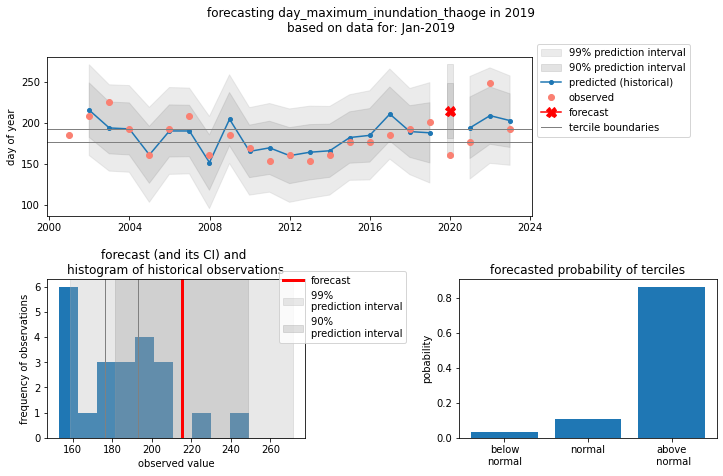

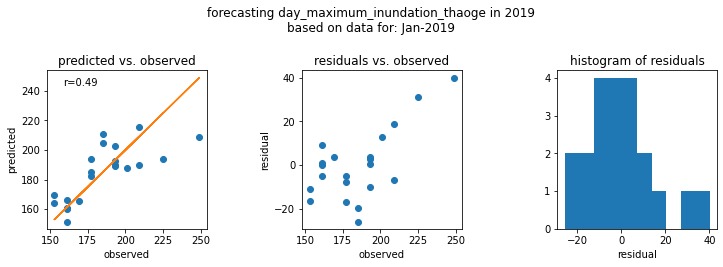

In [31]:
fcst,model,flprobs=forecast("day_maximum_inundation_thaoge","Jan",2019, verbose=True)